# Semi-Supervised VAE Project
## By VAEGen

## Setup

### Import libraries

In [1]:
import os
import time
import torch
import argparse
from functools import reduce
# 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Torch
import torch
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

### Meta parameters

In [2]:
batch_size=32*8*2
epochs=5
learning_rate=1e-3
latent_dim = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
#print layers, used for debugging
NNprint_ = False
classes=[0,1,2,3,4]
num_classes=len(classes)

### Import MNIST Dataset

In [3]:
# transforms arrays into tensors, can be extended
transformations = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Lambda(lambda p: Bernoulli(probs=p).sample())])

# define the train and test sets
dset_train = MNIST(root='data', train=True,  transform=transformations, download=True)
dset_test  = MNIST(root='data', train=False, transform=transformations)

def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets,classes))
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets,classes))

### Import FashionMNIST Dataset

In [4]:
train = FashionMNIST(
    root='data', train=True, transform=transforms.ToTensor(),
    download=True)
test= FashionMNIST(
    root='data', train=False, transform=transforms.ToTensor(),
    download=False)

### Configure Loaders

In [5]:
train_loader = torch.utils.data.DataLoader(
  train,
  batch_size=batch_size,sampler=stratified_sampler(train.targets,classes))

test_loader = torch.utils.data.DataLoader(
  test,
  batch_size=batch_size,sampler=stratified_sampler(test.targets,classes))

In [6]:
#https://github.com/wohlert/semi-supervised-pytorch/blob/master/semi-supervised/utils.py
def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

In [7]:
n_labels = 10
def get_mnist(location="./data", batch_size=64, labels_per_class=100):
    from functools import reduce
    from operator import __or__
    from torch.utils.data.sampler import SubsetRandomSampler
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms

    flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))

    def get_sampler(labels, n=None):
        # Only choose digits in n_labels
        (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

        # Ensure uniform distribution of labels
        np.random.shuffle(indices)
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])

        indices = torch.from_numpy(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=device,
                                           sampler=get_sampler(mnist_train.train_labels.numpy(), labels_per_class))
    unlabelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=device,
                                             sampler=get_sampler(mnist_train.train_labels.numpy()))
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, num_workers=2, pin_memory=device,
                                             sampler=get_sampler(mnist_valid.test_labels.numpy()))

    return labelled, unlabelled, validation

In [8]:
labelled, unlabelled, validation = get_mnist(location="./data", batch_size=64, labels_per_class=10)

/home/benjamin/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/benjamin/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [9]:

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data[0].shape)

torch.Size([1, 28, 28])


### Plot examples

In [10]:

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros=torch.zeros(num_classes,1024)
                samples= torch.cat((torch.rand(latent_dim,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
          plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([2

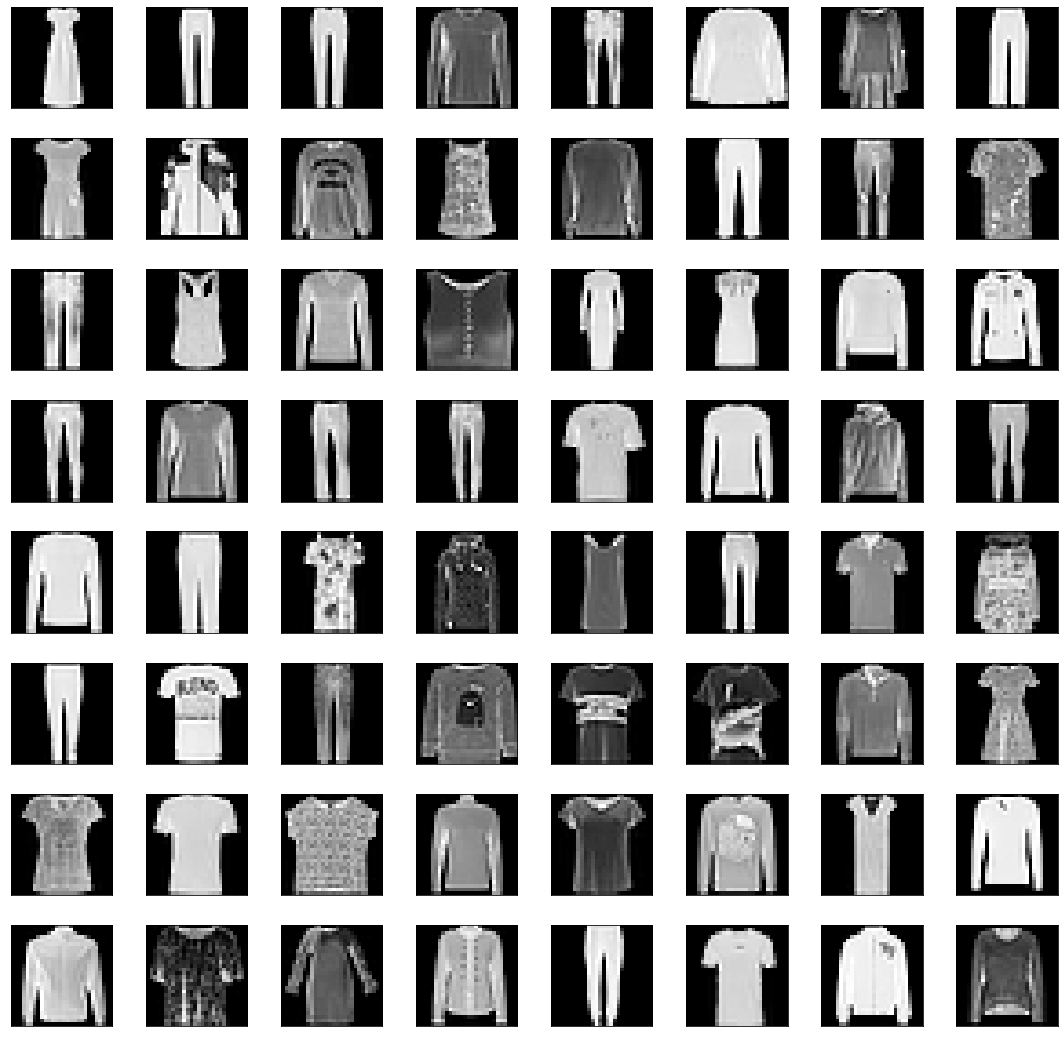

In [11]:
plot_examples()

### Torch auxiliary modules

In [12]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

# Debugging module 
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input  

## Deep Generative Model
Input: unlabeled data $[(x_v,)]$ and labeled data $[(x_s,y_s)]$
1. Run VAE on $[x_v + x_s]$.
2. Create linear classifier with input of latent vector size and output equal to number of classes.
3. Train classifier on $(\mu_s,y_s)$ where $\mu_s = vae.encode(x_s).\mu$

In [56]:
class Classifier(torch.nn.Module):
    def __init__(self, h_dimensions, input_size=28*28,z_dim=15):
        # Input dimensions is 3 item tuple: in_dim, hidden_dim, out_dim
        super(Classifier,self).__init__()
        layers = torch.nn.ModuleList()
        layers.append(torch.nn.Linear(input_size,h_dimensions[0]))
        layers.append(torch.nn.ReLU())
        for i in range(0,len(h_dimensions)-1):
            layers.append(torch.nn.Linear(h_dimensions[i],h_dimensions[i+1]))
            layers.append(torch.nn.ReLU())
            
        layers.append(torch.nn.Linear(h_dimensions[-1],z_dim))
        layers.append(torch.nn.Softmax())
                      
        self.net = torch.nn.Sequential(layers)
   
    def forward(self, x):       
        return self.net(x)
    
#clas = Classifier([25,100])
#print(clas)
    

Classifier(
  (net): Sequential(
    (0): ModuleList(
      (0): Linear(in_features=784, out_features=25, bias=True)
      (1): ReLU()
      (2): Linear(in_features=25, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=15, bias=True)
      (5): Softmax(dim=None)
    )
  )
)


In [58]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size=28*28,categories=10, image_channels=1, latent_size=15):
        super(Encoder, self).__init__()
        self.encode = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),            
            NNprint()
        )
        conv_out = 12345#todo
        self.lin = torch.nn.Linear(conv_out+categories, latent_size)
        
    def forward(self, x, y):
            x = self.encode(x)
            out = self.lin(torch.cat([x,y],1))
            return out
 ##TODO   
class Decoder(torch.nn.Module):
    def __init__(self, image_channels=1, latent_size=15):
        super(Decoder, self).__init__()
        self.decode = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(latent_size, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )
    def forward(self, x):
            return self.decode(x)
    
    
    
enc = Encoder()
print(enc)


dec = Decoder()
print(dec)
    
    

Encoder(
  (encode): Sequential(
    (0): NNprint()
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (2): NNprint()
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): NNprint()
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): NNprint()
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): NNprint()
    (12): LeakyReLU(negative_slope=0.01)
    (13): Flatten()
    (14): NNprint()
  )
  (lin): Linear(in_features=12355, out_features=15, bias=True)
)
Decoder(
  (decode): Sequential(
    (0): NNprint()
    (1): UnFlatten()
    (2): NNprint()
    (3): ConvTranspose2d(15, 128, kernel_size=(4, 4), stride=(2, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): NNprint()
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0.01)
    (8): NNprint()
    (9): ConvT

In [59]:
# temp solution - does it use var or logvar?
def log_gaussian_prob(x,mean,var):
    d=x.size(1)
    return -d/2*np.log(2*np.pi)-1/2*torch.sum(torch.log(var+1e-10),1)-1/2*torch.sum((x-mean)**2/var,1)


class VAEGenModel(torch.nn.Module): #M2
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32,num_labels=0,categories=10):
        super(VAEGenModel, self).__init__()
        
        
        self.alpha = alpha
        
        self.categories = categories
        #Encoder
        self.encode = Encoder(latent_size=z_dim) 
        #Decoder
        self.decode = Decoder(image_channels, latent_size=z_dim)
        #Classifier
        self.classifier = Classifier([200, 100],z_dim=z_dim)



    def forward(self, x_lab, y_lab, x_no_lab):
        
        ## Labelled Learning
        
        
        # encode to get mu and logvar
        z_mu, z_logvar = self.encode(x_lab,y_lab)
        
        # sample z ~ q(z|x,y)
        z = torch.rand_like(z_mu,z_logvar) * torch.sqrt(z_logvar) + z_mu
              
        # 
        log_q_z = log_gaussian_prob(x, z_mu, z_logvar)
        
        # decode y,z to x by sampling
        x = self.decode(torch.cat([z,y_lab]),1)[0] #[0]?
        
        # log p(x|y,z) aka reconstruction error
        log_p_x = -torch.sum(F.binary_cross_entropy_with_logits(x,x_lab,reduction='none'),1)
        
        # log p(y), which is evenly distributed in our case
        log_p_y = np.log(1/self.categories)
        
        # log p(z), gaussian dist with mu=0 and logvar=1
        log_p_z = log_gaussian_prob(z,torch.zeros_like(z), torch.ones_like(z))
        
        # Labelled loss: -L(x,y)=
        loss_lab = -1*torch.mean(log_p_x+log_p_y+log_p_z-log_q_z)
        
        ## Supervised Learning
        
        # classification
        y_ = self.classifier(lab_x)[0] #[0]?
        
        # classification loss: alpha*
        loss_class = self.alpha * F.cross_entropy(y_,torch.argmax(y_lab,1),reduction='mean')
        
        q_y = 
        
        
        
        
        
        
        
        
        
        
        
        return z
    
    
vae = VAEGenModel()
print(vae)

VAEGenModel(
  (encoder): Encoder(
    (encode): Sequential(
      (0): NNprint()
      (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
      (2): NNprint()
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (5): NNprint()
      (6): LeakyReLU(negative_slope=0.01)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (8): NNprint()
      (9): LeakyReLU(negative_slope=0.01)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (11): NNprint()
      (12): LeakyReLU(negative_slope=0.01)
      (13): Flatten()
      (14): NNprint()
    )
    (lin): Linear(in_features=12355, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): NNprint()
      (1): UnFlatten()
      (2): NNprint()
      (3): ConvTranspose2d(32, 128, kernel_size=(4, 4), stride=(2, 2))
      (4): LeakyReLU(negative_slope=0.01)
      (5): NNprint()
      (6): ConvTranspose2d(128, 64, kernel_size=(5,

tensor([0.5082, 0.1439, 1.0121, 0.9596, 0.7301])

In [ ]:
def fit_model(model, train_loader):
    model.train()
    running_loss = 0.0
    # Run each batch in training dataset
    for idx, (images, labels) in enumerate(train_loader):
        recon_images, mu, logvar = model(images.to(device),None)
        loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    return running_loss/len(train_loader.dataset)
    

def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            recon_images, mu, logvar = model(images.to(device),None)
            loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
            running_loss += loss

    return running_loss/len(test_loader.dataset)

In [ ]:
%%time
##
train_loss = []
test_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit_model(model, train_loader)
    test_epoch_loss = test_model(model, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")

torch.save(model.state_dict(), 'cvae.torch')


In [ ]:
plot_examples()

In [ ]:
#Reconstructions
plot_examples(model)


In [ ]:
# Sample latent space
plot_examples(model,sample=True)

In [ ]:
# 

z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)
z3 = torch.randn(1, latent_dim).to(device)
z4 = torch.randn(1, latent_dim).to(device)

y = torch.randint(0, 10,(1,1)).to(dtype=torch.long) # 10=number of classes
y = torch.nn.functional.one_hot(y,10).type(torch.float).to(device,dtype=z.dtype)[0]

z1 = torch.cat((z1,y),dim=1)
z2 = torch.cat((z2,y),dim=1)
z3 = torch.cat((z3,y),dim=1)
z4 = torch.cat((z4,y),dim=1)

print(z1)
print(z2)
print(z3)
print(z4)
rec1 = model.decode(z1)
rec2 = model.decode(z2)
rec3 = model.decode(z3)
rec4 = model.decode(z4)

img1 = rec1.view(28,28).data
img2 = rec2.view(28,28).data
img3 = rec3.view(28,28).data
img4 = rec4.view(28,28).data


In [ ]:
plt.figure()
plt.imshow(img1.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img2.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img3.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img4.to('cpu'), cmap='gray')